## install some resources

In [141]:
import os
HOME = os.getcwd()
print(HOME)

/content/ByteTrack/ByteTrack/ByteTrack


In [142]:
# Install gdown if not already installed
!pip install gdown --quiet

# Download the file from Google Drive
file_id = "1pz68D1Gsx80MoPg-_q-IbEdESEmyVLm-"
!gdown "https://drive.google.com/uc?id={file_id}" -O CarDetection.mp4

print("Download complete. File saved as 'video.mp4'")

Downloading...
From: https://drive.google.com/uc?id=1pz68D1Gsx80MoPg-_q-IbEdESEmyVLm-
To: /content/ByteTrack/ByteTrack/ByteTrack/CarDetection.mp4
100% 35.3M/35.3M [00:01<00:00, 26.1MB/s]
Download complete. File saved as 'video.mp4'


In [143]:
SOURCE_VIDEO_PATH = f"{HOME}/content/input.mp4"

In [144]:
!pip install ultralytics

from IPython import display
display.clear_output()

In [145]:
!pip install loguru
!pip install lapx

from IPython import display
display.clear_output()

In [146]:
%cd {HOME}
!git clone https://github.com/ifzhang/ByteTrack.git
%cd {HOME}/ByteTrack

# workaround related to https://github.com/roboflow/notebooks/issues/80
!sed -i 's/onnx==1.8.1/onnx==1.9.0/g' requirements.txt

!pip3 install -q -r requirements.txt
!python3 setup.py -q develop
!pip install -q cython_bbox
!pip install -q onemetric
# workaround related to https://github.com/roboflow/notebooks/issues/112 and https://github.com/roboflow/notebooks/issues/106
!pip install -q loguru lap thop



from IPython import display
display.clear_output()

In [147]:
!pip install supervision==0.1.0


from IPython import display
display.clear_output()


# install important library

In [148]:
import sys
sys.path.append(f"{HOME}/ByteTrack")

import ultralytics
ultralytics.checks()
from ultralytics import YOLO
import yolox
print("yolox.__version__:", yolox.__version__)
from yolox.tracker.byte_tracker import BYTETracker, STrack
from onemetric.cv.utils.iou import box_iou_batch
from dataclasses import dataclass
from typing import List
import numpy as np



import supervision
print("supervision.__version__:", supervision.__version__)
from supervision.draw.color import ColorPalette
from supervision.geometry.dataclasses import Point
from supervision.video.dataclasses import VideoInfo
from supervision.video.source import get_video_frames_generator
from supervision.video.sink import VideoSink
from supervision.notebook.utils import show_frame_in_notebook
from supervision.tools.detections import Detections, BoxAnnotator
from supervision.tools.line_counter import LineCounter, LineCounterAnnotator
from tqdm import tqdm

Ultralytics 8.3.49 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 33.7/112.6 GB disk)
yolox.__version__: 0.1.0
supervision.__version__: 0.1.0


#Using YOLO11n Model

In [201]:
yolo_model = "yolo11n.pt"

model = YOLO(yolo_model)
model.fuse()

100%|██████████| 5.35M/5.35M [00:00<00:00, 92.9MB/s]


YOLO11n summary (fused): 238 layers, 2,616,248 parameters, 0 gradients, 6.5 GFLOPs


# show classes

In [202]:
CLASS_NAMES_DICT = model.model.names
CLASS_NAMES_DICT

{0: 'person',
 1: 'bicycle',
 2: 'car',
 3: 'motorcycle',
 4: 'airplane',
 5: 'bus',
 6: 'train',
 7: 'truck',
 8: 'boat',
 9: 'traffic light',
 10: 'fire hydrant',
 11: 'stop sign',
 12: 'parking meter',
 13: 'bench',
 14: 'bird',
 15: 'cat',
 16: 'dog',
 17: 'horse',
 18: 'sheep',
 19: 'cow',
 20: 'elephant',
 21: 'bear',
 22: 'zebra',
 23: 'giraffe',
 24: 'backpack',
 25: 'umbrella',
 26: 'handbag',
 27: 'tie',
 28: 'suitcase',
 29: 'frisbee',
 30: 'skis',
 31: 'snowboard',
 32: 'sports ball',
 33: 'kite',
 34: 'baseball bat',
 35: 'baseball glove',
 36: 'skateboard',
 37: 'surfboard',
 38: 'tennis racket',
 39: 'bottle',
 40: 'wine glass',
 41: 'cup',
 42: 'fork',
 43: 'knife',
 44: 'spoon',
 45: 'bowl',
 46: 'banana',
 47: 'apple',
 48: 'sandwich',
 49: 'orange',
 50: 'broccoli',
 51: 'carrot',
 52: 'hot dog',
 53: 'pizza',
 54: 'donut',
 55: 'cake',
 56: 'chair',
 57: 'couch',
 58: 'potted plant',
 59: 'bed',
 60: 'dining table',
 61: 'toilet',
 62: 'tv',
 63: 'laptop',
 64: 'mou

In [203]:
CLASS_ID = [2,3,5,7]

# Take one frame and apply model


0: 384x640 11 cars, 1 truck, 14.7ms
Speed: 3.9ms preprocess, 14.7ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


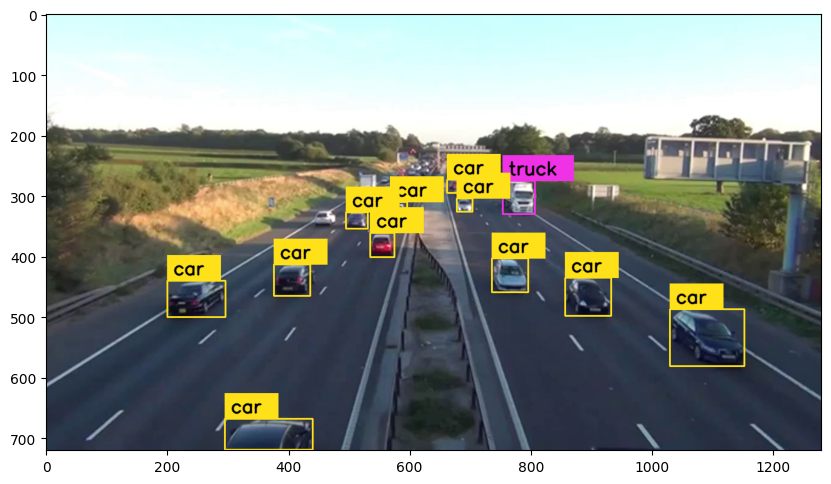

In [204]:
# create frame generator
generator = get_video_frames_generator("/content/input.mp4")
# create instance of BoxAnnotator
box_annotator = BoxAnnotator(color=ColorPalette(), thickness=2, text_thickness=2, text_scale=1)
# acquire first video frame
iterator = iter(generator)
frame = next(iterator)
# model prediction on single frame and conversion to supervision Detections
results = model(frame)
detections = Detections(
    xyxy=results[0].boxes.xyxy.cpu().numpy(),
    confidence=results[0].boxes.conf.cpu().numpy(),
    class_id=results[0].boxes.cls.cpu().numpy().astype(int)
)
# format custom labels
labels = [
    f"{CLASS_NAMES_DICT[class_id]} "
    for _, confidence, class_id, tracker_id
    in detections
]
# annotate and display frame
frame = box_annotator.annotate(frame=frame, detections=detections, labels=labels)

%matplotlib inline
show_frame_in_notebook(frame, (10, 8))

In [205]:
results

[ultralytics.engine.results.Results object with attributes:
 
 boxes: ultralytics.engine.results.Boxes object
 keypoints: None
 masks: None
 names: {0: 'person', 1: 'bicycle', 2: 'car', 3: 'motorcycle', 4: 'airplane', 5: 'bus', 6: 'train', 7: 'truck', 8: 'boat', 9: 'traffic light', 10: 'fire hydrant', 11: 'stop sign', 12: 'parking meter', 13: 'bench', 14: 'bird', 15: 'cat', 16: 'dog', 17: 'horse', 18: 'sheep', 19: 'cow', 20: 'elephant', 21: 'bear', 22: 'zebra', 23: 'giraffe', 24: 'backpack', 25: 'umbrella', 26: 'handbag', 27: 'tie', 28: 'suitcase', 29: 'frisbee', 30: 'skis', 31: 'snowboard', 32: 'sports ball', 33: 'kite', 34: 'baseball bat', 35: 'baseball glove', 36: 'skateboard', 37: 'surfboard', 38: 'tennis racket', 39: 'bottle', 40: 'wine glass', 41: 'cup', 42: 'fork', 43: 'knife', 44: 'spoon', 45: 'bowl', 46: 'banana', 47: 'apple', 48: 'sandwich', 49: 'orange', 50: 'broccoli', 51: 'carrot', 52: 'hot dog', 53: 'pizza', 54: 'donut', 55: 'cake', 56: 'chair', 57: 'couch', 58: 'potted p

# make detection on all frames

In [206]:
TARGET_VIDEO_PATH1 = f"{HOME}/input.mp4"
TARGET_VIDEO_PATH2 = f"{HOME}/output.mp4"

In [207]:
video_info=VideoInfo.from_video_path("/content/input.mp4")

In [208]:
video_info

VideoInfo(width=1280, height=720, fps=30, total_frames=629)

In [209]:
def detections2boxes(detections: Detections) -> np.ndarray:
    return np.hstack((
        detections.xyxy,
        detections.confidence[:, np.newaxis]
    ))


# converts List[STrack] into format that can be consumed by match_detections_with_tracks function
def tracks2boxes(tracks: List[STrack]) -> np.ndarray:
    return np.array([track.tlbr for track in tracks], dtype=float)


# matches our bounding boxes with predictions
def match_detections_with_tracks(detections: Detections,tracks: List[STrack]) -> Detections:
    if not np.any(detections.xyxy) or len(tracks) == 0:
        return np.empty((0,))

    tracks_boxes = tracks2boxes(tracks=tracks)
    iou = box_iou_batch(tracks_boxes, detections.xyxy)
    track2detection = np.argmax(iou, axis=1)

    tracker_ids = [None] * len(detections)

    for tracker_index, detection_index in enumerate(track2detection):
        if iou[tracker_index, detection_index] != 0:
            tracker_ids[detection_index] = tracks[tracker_index].track_id

    return tracker_ids

defines a set of configuration arguments for the BYTETracker, This design pattern ensures that the tracker settings are well-organized, clear, and resistant to unintended changes.

In [210]:
@dataclass(frozen=True)
class BYTETrackerArgs:
    track_thresh: float = 0.25
    track_buffer: int = 30
    match_thresh: float = 0.8
    aspect_ratio_thresh: float = 3.0
    min_box_area: float = 1.0
    mot20: bool = False

In [211]:
np.float = float
np.int = int   #module 'numpy' has no attribute 'int'
np.object = object    #module 'numpy' has no attribute 'object'
np.bool = bool

starting and ending points of a line in a 2D coordinate system

In [212]:
LINE_START = Point(100, 400)
LINE_END = Point(1200, 400)

ensure that the coordinate from line is correct


0: 384x640 11 cars, 1 truck, 10.5ms
Speed: 2.6ms preprocess, 10.5ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


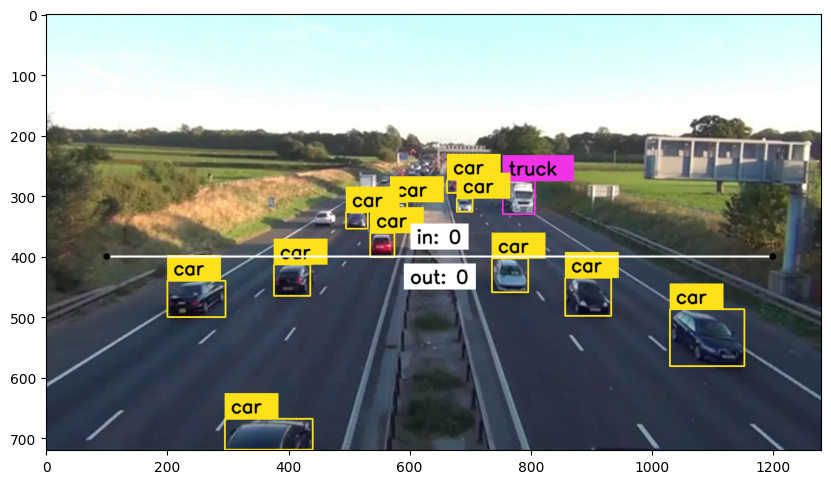

In [213]:
# create frame generator
generator = get_video_frames_generator("/content/input.mp4")
# create instance of BoxAnnotator
box_annotator = BoxAnnotator(color=ColorPalette(), thickness=2, text_thickness=2, text_scale=1)
line_annotator = LineCounterAnnotator(thickness=2, text_thickness=2, text_scale=1)
line_counter = LineCounter(start=LINE_START, end=LINE_END)
# acquire first video frame
iterator = iter(generator)
frame = next(iterator)
# model prediction on single frame and conversion to supervision Detections
results = model(frame)
detections = Detections(
    xyxy=results[0].boxes.xyxy.cpu().numpy(),
    confidence=results[0].boxes.conf.cpu().numpy(),
    class_id=results[0].boxes.cls.cpu().numpy().astype(int)
)
# format custom labels
labels = [
    f"{CLASS_NAMES_DICT[class_id]} "
    for _, confidence, class_id, tracker_id
    in detections
]
# annotate and display frame
frame = box_annotator.annotate(frame=frame, detections=detections, labels=labels)
line_annotator.annotate(frame=frame, line_counter=line_counter)

%matplotlib inline
show_frame_in_notebook(frame, (10, 8))

# loop over video frames

In [214]:
from tqdm.notebook import tqdm
import numpy as np
# create BYTETracker instance
byte_tracker = BYTETracker(BYTETrackerArgs())
# create VideoInfo instance
video_info = VideoInfo.from_video_path("/content/input.mp4")
# create frame generator
generator = get_video_frames_generator("/content/input.mp4")
# create LineCounter instance
line_counter = LineCounter(start=LINE_START, end=LINE_END)
# create instance of BoxAnnotator and LineCounterAnnotator
box_annotator = BoxAnnotator(color=ColorPalette(), thickness=2, text_thickness=2, text_scale=1)
line_annotator = LineCounterAnnotator(thickness=2, text_thickness=2, text_scale=1)

# open target video file
with VideoSink(TARGET_VIDEO_PATH2, video_info) as sink:
    # loop over video frames
    for frame in tqdm(generator, total=video_info.total_frames):
        # model prediction on single frame and conversion to supervision Detections
        results = model(frame)
        detections = Detections(
            xyxy=results[0].boxes.xyxy.cpu().numpy(),
            confidence=results[0].boxes.conf.cpu().numpy(),
            class_id=results[0].boxes.cls.cpu().numpy().astype(int)
        )
        # filtering out detections with unwanted classes
        mask = np.array([class_id in CLASS_ID for class_id in detections.class_id], dtype=bool)
        detections.filter(mask=mask, inplace=True)
        # tracking detections
        tracks = byte_tracker.update(
            output_results=detections2boxes(detections=detections),
            img_info=frame.shape,
            img_size=frame.shape
        )
        tracker_id = match_detections_with_tracks(detections=detections, tracks=tracks)
        detections.tracker_id = np.array(tracker_id)
        # filtering out detections without trackers
        mask = np.array([tracker_id is not None for tracker_id in detections.tracker_id], dtype=bool)
        detections.filter(mask=mask, inplace=True)
        # format custom labels
        labels = [
            f"#{tracker_id} {CLASS_NAMES_DICT[class_id]}"
            for _, confidence, class_id, tracker_id
            in detections
        ]
        # updating line counter
        line_counter.update(detections=detections)
        # annotate and display frame
        frame = box_annotator.annotate(frame=frame, detections=detections, labels=labels)
        line_annotator.annotate(frame=frame, line_counter=line_counter)
        sink.write_frame(frame)

  0%|          | 0/629 [00:00<?, ?it/s]


0: 384x640 11 cars, 1 truck, 9.5ms
Speed: 2.6ms preprocess, 9.5ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 cars, 1 truck, 11.9ms
Speed: 1.9ms preprocess, 11.9ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 cars, 1 truck, 8.9ms
Speed: 1.8ms preprocess, 8.9ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 cars, 1 truck, 9.8ms
Speed: 1.9ms preprocess, 9.8ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 cars, 2 trucks, 10.0ms
Speed: 1.9ms preprocess, 10.0ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 cars, 1 truck, 14.4ms
Speed: 2.0ms preprocess, 14.4ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 cars, 2 trucks, 9.2ms
Speed: 2.0ms preprocess, 9.2ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 cars, 2 trucks, 15.1ms
Speed: 2.0ms preprocess, 15.1m

# save output

In [215]:
from google.colab import files
files.download(TARGET_VIDEO_PATH2)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>